In [ ]:
#  connect to drive and load the data under /content/drive/ directory
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
import numpy as np

INIT_LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
DIRECTORY = "./"
CATEGORIES = ["with_mask", "without_mask"]

In [2]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import gc
import os, random
import cv2

In [4]:
data = np.array([])
labels = np.array([])
i = 0
for category in CATEGORIES:
    path_data = os.path.join(DIRECTORY, category)
    for img in os.listdir(path_data):
        img_path = os.path.join(path_data, img)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(224, 224), interpolation= cv2.INTER_AREA)
        image = preprocess_input(image)
        data = np.append(data, image)
        labels = np.append(labels, category)
        print("Processing ==>", img_path, '==>', i)
        i+=1
    gc.collect()

Processing ==> ./with_mask/with_mask_2640.jpg ==> 0
Processing ==> ./with_mask/with_mask_362.jpg ==> 1
Processing ==> ./with_mask/with_mask_1488.jpg ==> 2
Processing ==> ./with_mask/with_mask_2590.jpg ==> 3
Processing ==> ./with_mask/with_mask_2674.jpg ==> 4
Processing ==> ./with_mask/with_mask_2953.jpg ==> 5
Processing ==> ./with_mask/with_mask_3003.jpg ==> 6
Processing ==> ./with_mask/with_mask_1684.jpg ==> 7
Processing ==> ./with_mask/with_mask_18.jpg ==> 8
Processing ==> ./with_mask/with_mask_2560.jpg ==> 9
Processing ==> ./with_mask/with_mask_3390.jpg ==> 10
Processing ==> ./with_mask/with_mask_1841.jpg ==> 11
Processing ==> ./with_mask/with_mask_441.jpg ==> 12
Processing ==> ./with_mask/with_mask_2224.jpg ==> 13
Processing ==> ./with_mask/with_mask_2364.jpg ==> 14
Processing ==> ./with_mask/with_mask_1012.jpg ==> 15
Processing ==> ./with_mask/with_mask_274.jpg ==> 16
Processing ==> ./with_mask/with_mask_2302.jpg ==> 17
Processing ==> ./with_mask/with_mask_902.jpg ==> 18
Processin

In [16]:
prepared_data = np.reshape(data,(1200,224,224,3)), range(1200)
prepared_data[0][0].shape

(224, 224, 3)

In [5]:
prepared_data = np.reshape(data,(1200,224,224,3))
prepared_data[0].shape
labels

array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
       'without_mask', 'without_mask'], dtype='<U32')

In [17]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [19]:
from sklearn.model_selection import train_test_split
#data = np.reshape(data, (224, 224, 3))

x_train,x_test,y_train, y_test = train_test_split(prepared_data[0], labels, test_size = 0.2, random_state = 42, stratify=labels )
"""(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels,
                                                  random_state=42)"""

'(trainX, testX, trainY, testY) = train_test_split(data, labels,\n                                                  test_size=0.20, stratify=labels,\n                                                  random_state=42)'

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [30]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [22]:
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout, Dense
from tensorflow.keras.models import Model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [23]:
for layer in baseModel.layers:
  layer.trainable = False

In [24]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [26]:
H = model.fit( aug.flow(x_train, y_train, batch_size=BATCH_SIZE), steps_per_epoch=len(x_train) // BATCH_SIZE,
              validation_data=(x_test, y_test), validation_steps=len(x_test) // BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
30/30 [==============================] - 32s 1s/step - loss: 0.0419 - accuracy: 0.9865 - val_loss: 0.0762 - val_accuracy: 0.9792
Epoch 2/20
30/30 [==============================] - 31s 1s/step - loss: 0.0443 - accuracy: 0.9885 - val_loss: 0.0755 - val_accuracy: 0.9750
Epoch 3/20
30/30 [==============================] - 31s 1s/step - loss: 0.0454 - accuracy: 0.9844 - val_loss: 0.0775 - val_accuracy: 0.9708
Epoch 4/20
30/30 [==============================] - 31s 1s/step - loss: 0.0446 - accuracy: 0.9823 - val_loss: 0.0788 - val_accuracy: 0.9792
Epoch 5/20
30/30 [==============================] - 31s 1s/step - loss: 0.0455 - accuracy: 0.9885 - val_loss: 0.0741 - val_accuracy: 0.9792
Epoch 6/20
30/30 [==============================] - 46s 2s/step - loss: 0.0365 - accuracy: 0.9906 - val_loss: 0.0741 - val_accuracy: 0.9708
Epoch 7/20
30/30 [==============================] - 26s 850ms/step - loss: 0.0320 - accuracy: 0.9885 - val_loss: 0.0769 - val_accuracy: 0.9792
Epoch 8/20
30/30 

In [27]:
model.save("mask_detection3.h5")

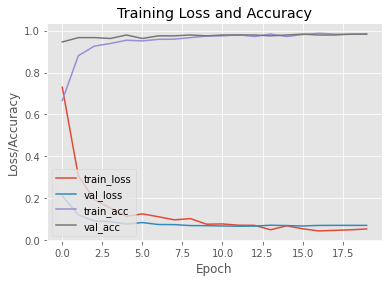

In [18]:
import matplotlib.pyplot as plt

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")